## Importing basic libraries for plots and matrix calculations

In [2]:
import numpy as np
import pandas as pd
import random
import os
import math
import pickle
import matplotlib.pyplot as plt

## Reading both feature and label text files and saving into dataframe and viewing first five records

In [3]:
data_img = pd.read_csv('MNISTnumImages5000.txt',sep="\t", header=None)

In [4]:
data_lbl = pd.read_csv('MNISTnumLabels5000.txt', sep="\t", header=None)

In [5]:
data_img.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0


In [6]:
data_lbl.head()

,0
0,7
1,2
2,1
3,0
4,4


## Distribution of records digit wise

In [8]:
data_lbl.iloc[:,0].value_counts()

1    571
2    530
9    520
7    512
3    500
4    500
8    489
6    462
0    460
5    456
Name: 0, dtype: int64

## Function to change target to 1,0 representation

In [9]:
def bin_encode(target):
    arr_target = np.zeros((10, 1))
    a=[]
    for i in range(10):
        if i==target:
            a.append([1.])
        else:
            a.append([0.])
    arr_target=np.array(a)
    return arr_target

## Activations functions and their derivative functions

In [10]:
def act_sig(u):
    v = 1.0 / (1.0 + np.exp(-u))
    return v

def act_sig_deri(u):
    v= act_sig(u) * (1 - act_sig(u))
    return v

def act_relu(u):
    v=np.maximum(u,0)
    return v

def act_relu_deri(u):
    u[u<=0]=0
    u[u>0]=1
    return u

def act_tanh(u,a,b):
    v = a * np.tanh(b * u)
    return v

def act_tanh_deri(u,a,b):
    v= (b/a) * ((a*a) - (u * u)) 
    return v

def get_act(act_fun,u):
    if act_fun=="sigmoid":
        return act_sig(u)
    elif act_fun=="relu":
        return act_relu(u)
    elif act_fun=="tanh":
        a=1.7159
        b=2/3
        return act_tanh(u,a,b)
    else:
        raise ValueError('Activation function not found')
        
def get_act_derv(act_fun,u):
    if act_fun=="sigmoid":
        return act_sig_deri(u)
    elif act_fun=="relu":
        return act_relu_deri(u)
    elif act_fun=="tanh":
        a=1.7159
        b=2/3
        return act_tanh_deri(u,a,b)
    else:
        raise ValueError('Activation function not found')
    

## Multi layer Feed forward network implementation with following parameters as inputs :
layers_list :- list containing input neurons , hidden layers neurons , output layer neurons in same order.
activations :- list containing corresponding activation functions (sigmoid, relu ,tanh) first element of list can be anything as                inputs will be first activations and so no need of activation function.
lr          :- learning rate
momentum    :- momentum
iters       :- epochs
bat_size    :- batch size for Stochaistic Gradient Descent
auto        :- flag to run second ques as it involves calculating cost function which is not needed for ques 1

In [14]:
class Model(object):

    def __init__(self, layer_list=list(),act_list=list(), lr=1.0,momentum=0.1,iters=10, bat_size=16, auto=False):
        
        self.eta = lr
        self.momentum = momentum
        self.iters = iters
        self.bat_size = bat_size
        self.auto=auto
        self.layer_list = layer_list
        self.layers_len = len(layer_list)
        self.act_list=act_list
        self.act_len = len(act_list)
        if self.layers_len != self.act_len:
            raise ValueError('Activations and Layers size should match')
            
        self.W=[]
        self.W.append(np.array([0]))
        for i in range(1,len(layer_list)):
            a=math.sqrt(6/layer_list[i-1])
            tmp=np.zeros((layer_list[i],layer_list[i-1]))
            for j in range(layer_list[i]):
                tmp[j]=np.random.uniform(-a, a, layer_list[i-1])
            self.W.append(tmp)
        
        self.B = [np.zeros((i,1)) for i in layer_list]
        self.S = [np.zeros((i,1)) for i in layer_list]
        self.A = [np.zeros((i,1)) for i in layer_list]
        
        if self.auto:
            self.store("auto-intial-"+str(self.layer_list[1])+".pkl")
        else:
            self.store("model-intial-"+str(self.layer_list[1])+".pkl")
        
       

    def train(self, dt_train, dt_val, dt_test, auto):
        
        flag=0
        thr=[]
        vhr=[]
        tehr=[]
        
        tc=[]
        vc=[]
        tec=[]
        
        if auto:
            train_cost = (self.getError(dt_train))
            val_cost = (self.getError(dt_val))
            test_cost =(self.getError(dt_test))
            tc.append(train_cost)
            vc.append(val_cost)
            tec.append(test_cost)
            print("For epoch {0}, validating error {1} , training error {2} , testing error {3}.".format(0,val_cost,train_cost,test_cost))
        else:
            train_hit_rate = (self.validateTrain(dt_train)) / (len(dt_train))
            val_hit_rate = (self.validate(dt_val)) / (len(dt_val))
            test_hit_rate =(self.validate(dt_test)) / (len(dt_test))
            thr.append(train_hit_rate)
            vhr.append(val_hit_rate)
            tehr.append(test_hit_rate)
            print("For epoch {0}, validating hit rate {1} , training hit rate {2} , testing hit rate {3}.".format(0,val_hit_rate,train_hit_rate,test_hit_rate))
         
        
        for itr in range(self.iters):
            random.shuffle(dt_train)
            train_subsets=[]
            for i in range(0, len(dt_train), self.bat_size):
                train_subsets.append(dt_train[i:i + self.bat_size])
            for dt_train_batch in train_subsets:
                delta_b = [np.zeros(b.shape) for b in self.B]
                main_delta_b= [np.zeros(b.shape) for b in self.B]
                
                delta_w = [np.zeros(w.shape) for w in self.W]
                main_delta_w= [np.zeros(w.shape) for w in self.W]
                for features, targets in dt_train_batch:
                    self.FP(features)
                    tmp_delta_b, tmp_delta_w = self.BP(targets)
                    delta_b = [db + tdb  for db, tdb in zip(delta_b, tmp_delta_b)]
                    delta_w = [dw + tdw  for dw, tdw in zip(delta_w, tmp_delta_w)]
                
                prev_delta_b = main_delta_b
                prev_delta_w = main_delta_w
                main_delta_w = [(-(self.eta / self.bat_size )* del_w) + (self.momentum * p_d_w) for del_w,p_d_w in zip (delta_w,prev_delta_w)] 
                main_delta_b = [(-(self.eta / self.bat_size )* del_b) + (self.momentum * p_d_b) for del_b,p_d_b in zip (delta_b,prev_delta_b)]
                
                self.updateWeights(main_delta_w, main_delta_b)
                #self.store("model-"+str(self.eta)+"-"+str(self.momentum)+str(self.act_list[1])+str(itr+1)+".pkl")

            if not (itr+1) % 10:
                if auto:
                    train_cost = (self.getError(dt_train))
                    val_cost = (self.getError(dt_val))
                    test_cost =(self.getError(dt_test))
                    tc.append(train_cost)
                    vc.append(val_cost)
                    tec.append(test_cost)
                    print("For epoch {0}, validating error {1} , training error {2} , testing error {3}.".format(itr + 1,val_cost,train_cost,test_cost))
                    if len(vc)>3:
                        if ((vc[-1]>vc[-2] and vc[-1] > vc[-3] and vc[-1] > vc[-4]) or (vc[-1] ==vc[-2] and vc[-1] ==vc[-2] and vc[-1] ==vc[-3])):
                            flag=1
                else:
                    train_hit_rate = (self.validateTrain(dt_train)) / (len(dt_train))
                    val_hit_rate = (self.validate(dt_val)) / (len(dt_val))
                    test_hit_rate =(self.validate(dt_test)) / (len(dt_test))
                    thr.append(train_hit_rate)
                    vhr.append(val_hit_rate)
                    tehr.append(test_hit_rate)
                    print("For epoch {0}, validating hit rate {1} , training hit rate {2} , testing hit rate {3}.".format(itr + 1,val_hit_rate,train_hit_rate,test_hit_rate))
                    if len(vhr)>3:
                        if ((vhr[-1]<vhr[-2] and vhr[-1] < vhr[-3] and vhr[-1] < vhr[-4]) or (vhr[-1] ==vhr[-2] and vhr[-1] ==vhr[-2] and vhr[-1] ==vhr[-3])):
                            flag=1
            #comment below code to run without stopping rule
            if flag==1:
                if auto:
                    self.store("auto-"+str(self.eta)+"-"+str(self.momentum)+str(self.act_list[-2])+'-'+str(self.act_list[-1])+str(itr+1)+".pkl")
                else:
                    self.store("model-"+str(self.eta)+"-"+str(self.momentum)+str(self.act_list[-2])+'-'+str(self.act_list[-1])+str(itr+1)+".pkl")
                break
                
            if not (itr+1) % 30:
                if auto:
                    self.store("auto-"+str(self.eta)+"-"+str(self.momentum)+str(self.act_list[-2])+'-'+str(self.act_list[-1])+str(itr+1)+".pkl")
                else:
                    self.store("model-"+str(self.eta)+"-"+str(self.momentum)+str(self.act_list[-2])+'-'+str(self.act_list[-1])+str(itr+1)+".pkl")
                    
        return {'thr':thr,'vhr':vhr,'tehr':tehr,'vc':vc,'tc':tc,'tec':tec}
                
    def getError(self,dt):
        mainCost=0
        for feat, targ in dt:
            pred=self.test_auto(feat)
            err=targ-pred
            sqEr=err  * err
            tmpCost=(1/2) * np.sum(sqEr)
            mainCost=mainCost+tmpCost
        return mainCost
    
    def updateWeights(self, main_delta_w, main_delta_b):
        
        self.W = [w + delw for w, delw  in zip(self.W, main_delta_w)]
        self.B = [b + delb for b, delb in zip(self.B, main_delta_b)]
    
    def validate(self, dt_val):
        corr_points=0
        for feat, targ in dt_val:
            if self.test(feat) == targ:
                corr_points=corr_points+1
        return corr_points
    
    def validateTrain(self, dt_val):
        ft = []
        lb=  []
        for i, j in dt_val:
            ft.append(i)
            lb.append(np.argmax(j))
        dt=list(zip(ft,lb))
        corr_points=0
        for feat, targ in dt:
            if self.test(feat) == targ:
                corr_points=corr_points+1
        return corr_points

    def test(self, features):
        self.FP(features)
        return np.argmax(self.A[-1])
    
    def test_auto(self, features):
        self.FP(features)
        return self.A[-1]

    def FP(self, features):
        self.A[0] = features
        for i in range(1, self.layers_len):
            self.S[i] = (self.W[i].dot(self.A[i - 1]) + self.B[i])
            self.A[i] = get_act(self.act_list[i],self.S[i])
            
    def BP(self, target):
        delta_b = [np.zeros(b.shape) for b in self.B]
        delta_w = [np.zeros(w.shape) for w in self.W]
        #delta for output layer
        tmp_del = (self.A[-1]-target) * get_act_derv(self.act_list[-1],self.S[-1])
        delta_b[-1] = tmp_del
        delta_w[-1] = tmp_del.dot(self.A[-2].transpose())
        #delta for hidden layes
        for l in range(self.layers_len - 2, 0, -1):
            tmp_del = np.multiply(self.W[l + 1].transpose().dot(tmp_del),get_act_derv(self.act_list[l],self.S[l]))
            delta_b[l] = tmp_del
            delta_w[l] = tmp_del.dot(self.A[l - 1].transpose())
        return delta_b, delta_w

    def store(self, file='weights.pkl'):
        
        lr=self.eta 
        mm=self.momentum 
        iters=self.iters 
        bs=self.bat_size
        
        ll=self.layer_list 
        al=self.act_list
        
        W=self.W
        B=self.B
        
        dict={'lr':lr,'mm':mm,'iters':iters,'bs':bs,'ll':ll,'al':al,'W':W,'B':B}
        with open(os.path.join(os.curdir, file), 'wb') as f: 
            pickle.dump(dict, f)
        
    def load(self, epoch, lr,mm, file='weights.pkl', actFun_list=['NR','sigmoid','sigmoid']):
       
        with open(os.path.join(os.curdir, file),'rb') as f:  
            objb= pickle.load(f)
        self.eta=lr 
        self.momentum=mm
        self.iters = epoch
        self.bat_size=int(objb['bs'])
        self.act_list=actFun_list
        self.act_len = len(self.act_list)
        self.W = list(objb['W'])
        self.B = list(objb['B'])
        self.layer_list = [b.shape[0] for b in self.B]
        self.layers_len = len(self.layer_list)
        self.S = [np.zeros(b.shape) for b in self.B]
        self.A = [np.zeros(b.shape) for b in self.B]

## Splitting Data into train and test and viewing corresponding digit distribution

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data_img, data_lbl, test_size=0.2, random_state=0 , stratify=data_lbl)

In [9]:
Y_train.iloc[:,0].value_counts()

1    457
2    424
9    416
7    409
3    400
4    400
8    391
6    370
0    368
5    365
Name: 0, dtype: int64

In [10]:
Y_test.iloc[:,0].value_counts()

1    114
2    106
9    104
7    103
4    100
3    100
8     98
6     92
0     92
5     91
Name: 0, dtype: int64

## splitting train into train_new and validation dataset with 3500 points as train_new and 500 as validation set

In [11]:
X_train_new, X_valid, Y_train_new, Y_valid = train_test_split(X_train, Y_train, test_size=0.125, random_state=0 , stratify=Y_train)

In [12]:
Y_train_new.iloc[:,0].value_counts()

1    400
2    371
9    364
7    358
3    350
4    350
8    342
6    324
0    322
5    319
Name: 0, dtype: int64

In [13]:
Y_valid.iloc[:,0].value_counts()

1    57
2    53
9    52
7    51
4    50
3    50
8    49
6    46
5    46
0    46
Name: 0, dtype: int64

## Changing input and output into 2d array

In [15]:
arr_x_train = [np.reshape(X_train_new.iloc[i,:].tolist(), (len(X_train_new.columns), 1)) for i in range(len(X_train_new))]
arr_y_train = [bin_encode(y) for y in Y_train_new.iloc[:,0].tolist()]
data_train = list(zip(arr_x_train, arr_y_train))

In [16]:
arr_x_val = [np.reshape(X_valid.iloc[i,:].tolist(), (len(X_valid.columns), 1)) for i in range(len(X_valid))]
arr_y_val = Y_valid.iloc[:,0].tolist()
data_val = list(zip(arr_x_val, arr_y_val))

In [17]:
arr_x_test = [np.reshape(X_test.iloc[i,:].tolist(), (len(X_test.columns), 1)) for i in range(len(X_test))]
arr_y_test = Y_test.iloc[:,0].tolist()
data_test = list(zip(arr_x_test, arr_y_test))

## Preparing data for auto encoder where target variables will be same as input

In [20]:
arr_x_train_auto = [np.reshape(X_train_new.iloc[i,:].tolist(), (len(X_train_new.columns), 1)) for i in range(len(X_train_new))]
data_train_auto = list(zip(arr_x_train_auto, arr_x_train_auto))

In [21]:
arr_x_val_auto = [np.reshape(X_valid.iloc[i,:].tolist(), (len(X_valid.columns), 1)) for i in range(len(X_valid))]
data_val_auto = list(zip(arr_x_val_auto, arr_x_val_auto))

In [22]:
arr_x_test_auto = [np.reshape(X_test.iloc[i,:].tolist(), (len(X_test.columns), 1)) for i in range(len(X_test))]
data_test_auto = list(zip(arr_x_test_auto, arr_x_test_auto))

## Different Running Auto Encoder with specifications as given in code

In [21]:
# After balanced split

#initialize layer sizes as list
layers = [784,150,784]
act_funcs=['NR','sigmoid','sigmoid']
momentum = 0.3
lr = 0.1
itrs = 500
batch_size = 32

nn = Model(layers,act_funcs, lr, momentum, itrs, batch_size,True)

#training neural network
Run1=nn.train(data_train_auto, data_val_auto, data_test_auto,True)



For epoch 0, validating error 51325.82429781404 , training error 359197.3736787727 , testing error 102519.4327362917.
For epoch 10, validating error 4292.107003988454 , training error 30104.69710986043 , testing error 8846.288135007018.
For epoch 20, validating error 2924.673999828148 , training error 20160.311328598633 , testing error 6048.609818410179.
For epoch 30, validating error 2318.7882008104257 , training error 15709.372171455596 , testing error 4807.4475565808825.
For epoch 40, validating error 1976.3810244421497 , training error 13156.436525878971 , testing error 4105.529202948762.
For epoch 50, validating error 1750.5367860008744 , training error 11458.41741643627 , testing error 3646.780953636084.
For epoch 60, validating error 1591.0152336688834 , training error 10232.986150270253 , testing error 3320.6218745555498.
For epoch 70, validating error 1472.3639318873493 , training error 9300.958378251495 , testing error 3076.3247174160847.
For epoch 80, validating error 1377.3

## Running code from intial random weights chosen based on Xavier rule and using different parameter values

In [22]:
nn.load(500,0.1,0.3,'auto-intial-150.pkl',['NR','relu','relu'])
Run2=nn.train(data_train_auto, data_val_auto, data_test_auto,True)

For epoch 0, validating error 35469.01943892328 , training error 249359.58646060573 , testing error 71804.92002004193.
For epoch 10, validating error 11419.850017477436 , training error 80944.23397920502 , testing error 23297.16077981835.
For epoch 20, validating error 11489.45544188611 , training error 81442.04073897073 , testing error 23442.624142327502.
For epoch 30, validating error 11380.452085022198 , training error 80549.48126668809 , testing error 23211.564546522608.
For epoch 40, validating error 11370.703045930259 , training error 80385.94467432846 , testing error 23146.908015194003.
For epoch 50, validating error 10794.588066917397 , training error 75727.94889742599 , testing error 21864.52218962759.
For epoch 60, validating error 11389.794628006799 , training error 80556.90475741321 , testing error 23206.72911829923.
For epoch 70, validating error 11383.940843864859 , training error 80486.75680889298 , testing error 23193.095779058527.
For epoch 80, validating error 12451.1

In [23]:
nn.load(500,0.1,0.3,'auto-intial-150.pkl',['NR','relu','sigmoid'])
Run3=nn.train(data_train_auto, data_val_auto, data_test_auto,True)

For epoch 0, validating error 48646.67516466604 , training error 340361.8113108364 , testing error 97200.50603115957.
For epoch 10, validating error 1537.6542786458203 , training error 10019.615005014959 , testing error 3217.6605532980534.
For epoch 20, validating error 1018.493853315582 , training error 6232.385428394272 , testing error 2136.529013265781.
For epoch 30, validating error 846.9096690644935 , training error 4904.420771478821 , testing error 1771.01692915884.
For epoch 40, validating error 766.483424728851 , training error 4265.033228225252 , testing error 1605.5295303051385.
For epoch 50, validating error 706.4698230442832 , training error 3804.4962165409615 , testing error 1490.6766951435918.
For epoch 60, validating error 672.2618611327798 , training error 3507.9675472084086 , testing error 1419.261225689292.
For epoch 70, validating error 642.180107275415 , training error 3272.169602350118 , testing error 1357.4474847194008.
For epoch 80, validating error 618.361983297

In [24]:
nn.load(500,0.1,0.7,'auto-intial-150.pkl',['NR','sigmoid','sigmoid'])
Run4=nn.train(data_train_auto, data_val_auto, data_test_auto,True)

For epoch 0, validating error 51325.82429781404 , training error 359197.37367877323 , testing error 102519.4327362917.
For epoch 10, validating error 4288.708346895935 , training error 30108.900344037844 , testing error 8848.144510778255.
For epoch 20, validating error 2923.8642229013108 , training error 20168.711540099455 , testing error 6048.010056735223.
For epoch 30, validating error 2318.680754989711 , training error 15715.404788054007 , testing error 4811.582983870508.
For epoch 40, validating error 1975.7193680322814 , training error 13154.677983191186 , testing error 4107.401673722177.
For epoch 50, validating error 1750.9360987085113 , training error 11455.745895717311 , testing error 3647.6944111421158.
For epoch 60, validating error 1590.3468513218143 , training error 10228.608498785994 , testing error 3318.98166266461.
For epoch 70, validating error 1470.610352004956 , training error 9297.175292566426 , testing error 3073.128086822111.
For epoch 80, validating error 1375.35

In [25]:
nn.load(500,0.1,0.7,'auto-intial-150.pkl',['NR','relu','relu'])
Run5=nn.train(data_train_auto, data_val_auto, data_test_auto,True)

For epoch 0, validating error 35469.01943892328 , training error 249359.58646060672 , testing error 71804.92002004193.
For epoch 10, validating error 11442.63637278893 , training error 81506.09091558012 , testing error 23511.07285656681.
For epoch 20, validating error 11497.297260817815 , training error 81590.74693108202 , testing error 23520.636735269403.
For epoch 30, validating error 11484.271308471087 , training error 81482.26108749006 , testing error 23438.332694178844.
For epoch 40, validating error 10750.332233111163 , training error 75612.20711687442 , testing error 21872.257894038816.
For epoch 50, validating error 11798.516008275777 , training error 83193.88789520568 , testing error 23913.70089130974.
For epoch 60, validating error 11403.07548563618 , training error 80915.86585356461 , testing error 23310.916721748607.
For epoch 70, validating error 11462.515985276197 , training error 81111.67672013621 , testing error 23358.94021547687.
For epoch 80, validating error 11438.90

In [26]:
nn.load(500,0.1,0.7,'auto-intial-150.pkl',['NR','relu','sigmoid'])
Run6=nn.train(data_train_auto, data_val_auto, data_test_auto,True)

For epoch 0, validating error 48646.67516466604 , training error 340361.81131083623 , testing error 97200.50603115957.
For epoch 10, validating error 1614.60932697024 , training error 10464.310268477224 , testing error 3356.5743066937403.
For epoch 20, validating error 1081.0584036038838 , training error 6695.652188393946 , testing error 2271.9370722777553.
For epoch 30, validating error 884.3574318105017 , training error 5147.695879877385 , testing error 1857.1875801862611.
For epoch 40, validating error 792.4682170608206 , training error 4462.111690007208 , testing error 1674.096254307136.
For epoch 50, validating error 734.9475879976502 , training error 3995.33177357648 , testing error 1549.344308643134.
For epoch 60, validating error 690.7982640602241 , training error 3650.158322972768 , testing error 1462.750247296232.
For epoch 70, validating error 662.2302073862239 , training error 3387.0431419161837 , testing error 1405.2743634552126.
For epoch 80, validating error 633.41202175

In [27]:
nn.load(500,0.01,0.7,'auto-intial-150.pkl',['NR','relu','sigmoid'])
Run7=nn.train(data_train_auto, data_val_auto, data_test_auto,True)

For epoch 0, validating error 48646.67516466604 , training error 340361.81131083507 , testing error 97200.50603115957.
For epoch 10, validating error 5641.71688250013 , training error 39714.89955271262 , testing error 11573.883780974385.
For epoch 20, validating error 3696.329848324298 , training error 25761.10205253096 , testing error 7633.8517098421835.
For epoch 30, validating error 2769.3858145968575 , training error 19096.81019647028 , testing error 5751.342183986341.
For epoch 40, validating error 2268.780451889331 , training error 15467.12019784726 , testing error 4719.086898968123.
For epoch 50, validating error 1954.8663503301736 , training error 13175.03619436253 , testing error 4074.4462579688197.
For epoch 60, validating error 1739.3283063235049 , training error 11607.505460511002 , testing error 3632.46424234366.
For epoch 70, validating error 1578.3293989719386 , training error 10442.678503247651 , testing error 3296.9369441163117.
For epoch 80, validating error 1460.0583

In [28]:
nn.load(500,0.001,0.7,'auto-intial-150.pkl',['NR','relu','sigmoid'])
Run8=nn.train(data_train_auto, data_val_auto, data_test_auto,True)

For epoch 0, validating error 48646.67516466604 , training error 340361.8113108356 , testing error 97200.50603115957.
For epoch 10, validating error 12205.47684247225 , training error 86142.01186480718 , testing error 24847.359534382682.
For epoch 20, validating error 10788.501320388139 , training error 76077.99356740438 , testing error 21959.759004121475.
For epoch 30, validating error 9578.37599169647 , training error 67535.51894688452 , testing error 19506.93990697857.
For epoch 40, validating error 8621.070155986363 , training error 60799.481352218834 , testing error 17567.663639035545.
For epoch 50, validating error 7857.642736052318 , training error 55425.59942328397 , testing error 16031.468340099593.
For epoch 60, validating error 7235.228479051181 , training error 51016.61421546114 , testing error 14776.573717690611.
For epoch 70, validating error 6718.28433175657 , training error 47370.888261327855 , testing error 13742.843182006398.
For epoch 80, validating error 6283.996904

## Running multi layer feed forward network for mnist data

In [29]:
# After balanced split

#initialize layer sizes as list
layers = [784,150,10]
act_funcs=['NR','sigmoid','sigmoid']
momentum = 0.3
lr = 0.01
itrs = 500
batch_size = 32

nn = Model(layers,act_funcs, lr, momentum, itrs, batch_size,False)

#training neural network
Run9=nn.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.09 , training hit rate 0.08828571428571429 , testing hit rate 0.108.
For epoch 10, validating hit rate 0.35 , training hit rate 0.3377142857142857 , testing hit rate 0.339.
For epoch 20, validating hit rate 0.44 , training hit rate 0.43657142857142855 , testing hit rate 0.447.
For epoch 30, validating hit rate 0.536 , training hit rate 0.5525714285714286 , testing hit rate 0.563.
For epoch 40, validating hit rate 0.628 , training hit rate 0.6405714285714286 , testing hit rate 0.651.
For epoch 50, validating hit rate 0.688 , training hit rate 0.7017142857142857 , testing hit rate 0.698.
For epoch 60, validating hit rate 0.73 , training hit rate 0.74 , testing hit rate 0.73.
For epoch 70, validating hit rate 0.76 , training hit rate 0.7657142857142857 , testing hit rate 0.75.
For epoch 80, validating hit rate 0.778 , training hit rate 0.7805714285714286 , testing hit rate 0.777.
For epoch 90, validating hit rate 0.796 , training hit rate 0.7934285714285

In [30]:
nn.load(500,0.01,0.3,'model-intial-150.pkl',['NR','relu','relu'])
Run10=nn.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.11 , training hit rate 0.11457142857142857 , testing hit rate 0.131.
For epoch 10, validating hit rate 0.708 , training hit rate 0.7114285714285714 , testing hit rate 0.696.
For epoch 20, validating hit rate 0.726 , training hit rate 0.7368571428571429 , testing hit rate 0.707.
For epoch 30, validating hit rate 0.728 , training hit rate 0.7514285714285714 , testing hit rate 0.715.
For epoch 40, validating hit rate 0.73 , training hit rate 0.7622857142857142 , testing hit rate 0.727.
For epoch 50, validating hit rate 0.908 , training hit rate 0.938 , testing hit rate 0.897.
For epoch 60, validating hit rate 0.916 , training hit rate 0.954 , testing hit rate 0.907.
For epoch 70, validating hit rate 0.916 , training hit rate 0.9634285714285714 , testing hit rate 0.907.
For epoch 80, validating hit rate 0.916 , training hit rate 0.9702857142857143 , testing hit rate 0.916.
For epoch 90, validating hit rate 0.914 , training hit rate 0.9734285714285714 , te

In [31]:
nn.load(500,0.01,0.3,'model-intial-150.pkl',['NR','relu','sigmoid'])
Run11=nn.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.11 , training hit rate 0.11457142857142857 , testing hit rate 0.131.
For epoch 10, validating hit rate 0.69 , training hit rate 0.6968571428571428 , testing hit rate 0.704.
For epoch 20, validating hit rate 0.806 , training hit rate 0.8168571428571428 , testing hit rate 0.824.
For epoch 30, validating hit rate 0.832 , training hit rate 0.8485714285714285 , testing hit rate 0.856.
For epoch 40, validating hit rate 0.866 , training hit rate 0.8625714285714285 , testing hit rate 0.866.
For epoch 50, validating hit rate 0.87 , training hit rate 0.8725714285714286 , testing hit rate 0.869.
For epoch 60, validating hit rate 0.868 , training hit rate 0.8822857142857143 , testing hit rate 0.875.
For epoch 70, validating hit rate 0.87 , training hit rate 0.8885714285714286 , testing hit rate 0.878.
For epoch 80, validating hit rate 0.87 , training hit rate 0.8942857142857142 , testing hit rate 0.88.
For epoch 90, validating hit rate 0.868 , training hit rate 0

In [32]:
nn.load(500,0.01,0.7,'model-intial-150.pkl',['NR','sigmoid','sigmoid'])
Run12=nn.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.09 , training hit rate 0.08828571428571429 , testing hit rate 0.108.
For epoch 10, validating hit rate 0.33 , training hit rate 0.332 , testing hit rate 0.33.
For epoch 20, validating hit rate 0.442 , training hit rate 0.43885714285714283 , testing hit rate 0.448.
For epoch 30, validating hit rate 0.548 , training hit rate 0.554 , testing hit rate 0.565.
For epoch 40, validating hit rate 0.628 , training hit rate 0.642 , testing hit rate 0.652.
For epoch 50, validating hit rate 0.692 , training hit rate 0.7002857142857143 , testing hit rate 0.696.
For epoch 60, validating hit rate 0.738 , training hit rate 0.7411428571428571 , testing hit rate 0.734.
For epoch 70, validating hit rate 0.762 , training hit rate 0.7645714285714286 , testing hit rate 0.751.
For epoch 80, validating hit rate 0.776 , training hit rate 0.7794285714285715 , testing hit rate 0.777.
For epoch 90, validating hit rate 0.798 , training hit rate 0.7954285714285714 , testing hit rat

In [33]:
nn.load(500,0.01,0.7,'model-intial-150.pkl',['NR','relu','relu'])
Run13=nn.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.11 , training hit rate 0.11457142857142857 , testing hit rate 0.131.
For epoch 10, validating hit rate 0.708 , training hit rate 0.7097142857142857 , testing hit rate 0.695.
For epoch 20, validating hit rate 0.724 , training hit rate 0.7374285714285714 , testing hit rate 0.705.
For epoch 30, validating hit rate 0.726 , training hit rate 0.7502857142857143 , testing hit rate 0.716.
For epoch 40, validating hit rate 0.736 , training hit rate 0.7637142857142857 , testing hit rate 0.727.
For epoch 50, validating hit rate 0.874 , training hit rate 0.9271428571428572 , testing hit rate 0.89.
For epoch 60, validating hit rate 0.912 , training hit rate 0.9551428571428572 , testing hit rate 0.905.
For epoch 70, validating hit rate 0.916 , training hit rate 0.9622857142857143 , testing hit rate 0.905.
For epoch 80, validating hit rate 0.916 , training hit rate 0.9682857142857143 , testing hit rate 0.913.
For epoch 90, validating hit rate 0.916 , training hit ra

In [34]:
nn.load(500,0.01,0.7,'model-intial-150.pkl',['NR','relu','sigmoid'])
Run14=nn.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.11 , training hit rate 0.11457142857142857 , testing hit rate 0.131.
For epoch 10, validating hit rate 0.688 , training hit rate 0.6968571428571428 , testing hit rate 0.703.
For epoch 20, validating hit rate 0.808 , training hit rate 0.816 , testing hit rate 0.818.
For epoch 30, validating hit rate 0.842 , training hit rate 0.8482857142857143 , testing hit rate 0.856.
For epoch 40, validating hit rate 0.856 , training hit rate 0.8622857142857143 , testing hit rate 0.867.
For epoch 50, validating hit rate 0.868 , training hit rate 0.8737142857142857 , testing hit rate 0.87.
For epoch 60, validating hit rate 0.87 , training hit rate 0.8817142857142857 , testing hit rate 0.875.
For epoch 70, validating hit rate 0.866 , training hit rate 0.8888571428571429 , testing hit rate 0.879.
For epoch 80, validating hit rate 0.872 , training hit rate 0.8937142857142857 , testing hit rate 0.884.
For epoch 90, validating hit rate 0.87 , training hit rate 0.8994285714

In [35]:
nn.load(500,0.1,0.7,'model-intial-150.pkl',['NR','relu','relu'])
Run15=nn.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.11 , training hit rate 0.11457142857142857 , testing hit rate 0.131.
For epoch 10, validating hit rate 0.736 , training hit rate 0.7805714285714286 , testing hit rate 0.735.
For epoch 20, validating hit rate 0.746 , training hit rate 0.7865714285714286 , testing hit rate 0.752.
For epoch 30, validating hit rate 0.746 , training hit rate 0.7865714285714286 , testing hit rate 0.747.
For epoch 40, validating hit rate 0.746 , training hit rate 0.7874285714285715 , testing hit rate 0.752.
For epoch 50, validating hit rate 0.75 , training hit rate 0.7877142857142857 , testing hit rate 0.747.
For epoch 60, validating hit rate 0.746 , training hit rate 0.7877142857142857 , testing hit rate 0.748.
For epoch 70, validating hit rate 0.746 , training hit rate 0.788 , testing hit rate 0.748.
For epoch 80, validating hit rate 0.748 , training hit rate 0.788 , testing hit rate 0.749.
For epoch 90, validating hit rate 0.746 , training hit rate 0.788 , testing hit rat

In [36]:
nn.load(500,0.001,0.7,'model-intial-150.pkl',['NR','relu','relu'])
Run16=nn.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.11 , training hit rate 0.11457142857142857 , testing hit rate 0.131.
For epoch 10, validating hit rate 0.366 , training hit rate 0.36914285714285716 , testing hit rate 0.382.
For epoch 20, validating hit rate 0.452 , training hit rate 0.4677142857142857 , testing hit rate 0.473.
For epoch 30, validating hit rate 0.552 , training hit rate 0.5577142857142857 , testing hit rate 0.571.
For epoch 40, validating hit rate 0.606 , training hit rate 0.618 , testing hit rate 0.633.
For epoch 50, validating hit rate 0.652 , training hit rate 0.6585714285714286 , testing hit rate 0.665.
For epoch 60, validating hit rate 0.676 , training hit rate 0.6817142857142857 , testing hit rate 0.679.
For epoch 70, validating hit rate 0.686 , training hit rate 0.6945714285714286 , testing hit rate 0.69.
For epoch 80, validating hit rate 0.696 , training hit rate 0.7005714285714286 , testing hit rate 0.691.
For epoch 90, validating hit rate 0.704 , training hit rate 0.7051428

In [40]:
Run9_tehr=Run9['tehr']
Run9_thr=Run9['thr']
Run9_vhr=Run9['vhr']
Run10_tehr=Run10['tehr']
Run10_thr=Run10['thr']
Run10_vhr=Run10['vhr']
Run11_tehr=Run11['tehr']
Run11_thr=Run11['thr']
Run11_vhr=Run11['vhr']
Run12_tehr=Run12['tehr']
Run12_thr=Run12['thr']
Run12_vhr=Run12['vhr']
Run13_tehr=Run13['tehr']
Run13_thr=Run13['thr']
Run13_vhr=Run13['vhr']
Run14_tehr=Run14['tehr']
Run14_thr=Run14['thr']
Run14_vhr=Run14['vhr']
Run15_tehr=Run15['tehr']
Run15_thr=Run15['thr']
Run15_vhr=Run15['vhr']
Run16_tehr=Run16['tehr']
Run16_thr=Run16['thr']
Run16_vhr=Run16['vhr']

## Different plots from hit rates saved

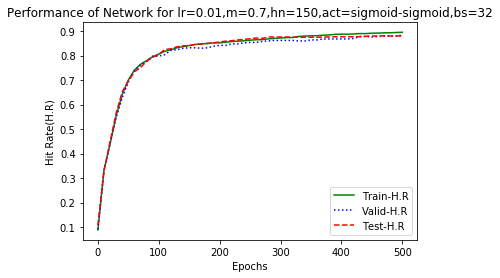

In [59]:
epoch = range(0,501,10)
plt.plot(epoch, Run12_thr, color='g',linestyle='-',label='Train-H.R')
plt.plot(epoch, Run12_vhr, color='blue' ,linestyle='dotted',label='Valid-H.R')
plt.plot(epoch, Run12_tehr, color='red',linestyle='dashed',label='Test-H.R')
plt.xlabel('Epochs')
plt.ylabel('Hit Rate(H.R)')
plt.legend()
plt.title('Performance of Network for lr=0.01,m=0.7,hn=150,act=sigmoid-sigmoid,bs=32')
plt.show()

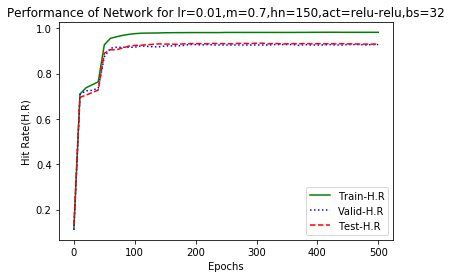

In [60]:
epoch = range(0,501,10)
plt.plot(epoch, Run13_thr, color='g',linestyle='-',label='Train-H.R')
plt.plot(epoch, Run13_vhr, color='blue' ,linestyle='dotted',label='Valid-H.R')
plt.plot(epoch, Run13_tehr, color='red',linestyle='dashed',label='Test-H.R')
plt.xlabel('Epochs')
plt.ylabel('Hit Rate(H.R)')
plt.legend()
plt.title('Performance of Network for lr=0.01,m=0.7,hn=150,act=relu-relu,bs=32')
plt.show()

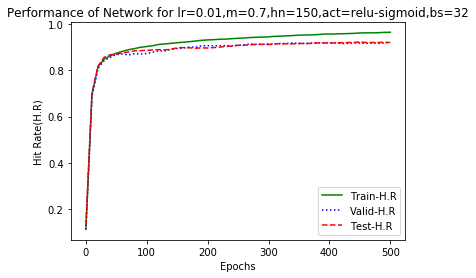

In [61]:
epoch = range(0,501,10)
plt.plot(epoch, Run14_thr, color='g',linestyle='-',label='Train-H.R')
plt.plot(epoch, Run14_vhr, color='blue' ,linestyle='dotted',label='Valid-H.R')
plt.plot(epoch, Run14_tehr, color='red',linestyle='dashed',label='Test-H.R')
plt.xlabel('Epochs')
plt.ylabel('Hit Rate(H.R)')
plt.legend()
plt.title('Performance of Network for lr=0.01,m=0.7,hn=150,act=relu-sigmoid,bs=32')
plt.show()

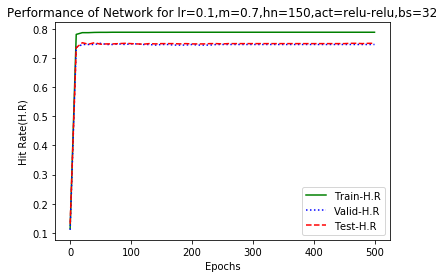

In [62]:
epoch = range(0,501,10)
plt.plot(epoch, Run15_thr, color='g',linestyle='-',label='Train-H.R')
plt.plot(epoch, Run15_vhr, color='blue' ,linestyle='dotted',label='Valid-H.R')
plt.plot(epoch, Run15_tehr, color='red',linestyle='dashed',label='Test-H.R')
plt.xlabel('Epochs')
plt.ylabel('Hit Rate(H.R)')
plt.legend()
plt.title('Performance of Network for lr=0.1,m=0.7,hn=150,act=relu-relu,bs=32')
plt.show()

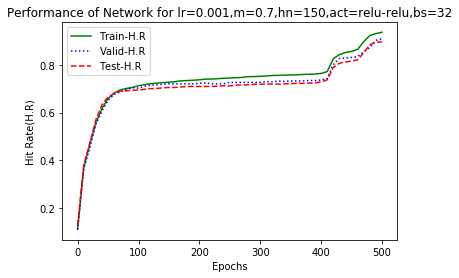

In [63]:
epoch = range(0,501,10)
plt.plot(epoch, Run16_thr, color='g',linestyle='-',label='Train-H.R')
plt.plot(epoch, Run16_vhr, color='blue' ,linestyle='dotted',label='Valid-H.R')
plt.plot(epoch, Run16_tehr, color='red',linestyle='dashed',label='Test-H.R')
plt.xlabel('Epochs')
plt.ylabel('Hit Rate(H.R)')
plt.legend()
plt.title('Performance of Network for lr=0.001,m=0.7,hn=150,act=relu-relu,bs=32')
plt.show()

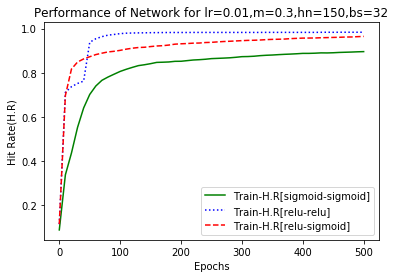

In [65]:
epoch = range(0,501,10)
plt.plot(epoch, Run9_thr, color='g',linestyle='-',label='Train-H.R[sigmoid-sigmoid]')
plt.plot(epoch, Run10_thr, color='blue' ,linestyle='dotted',label='Train-H.R[relu-relu]')
plt.plot(epoch, Run11_thr, color='red',linestyle='dashed',label='Train-H.R[relu-sigmoid]')
plt.xlabel('Epochs')
plt.ylabel('Hit Rate(H.R)')
plt.legend()
plt.title('Performance of Network for lr=0.01,m=0.3,hn=150,bs=32')
plt.show()

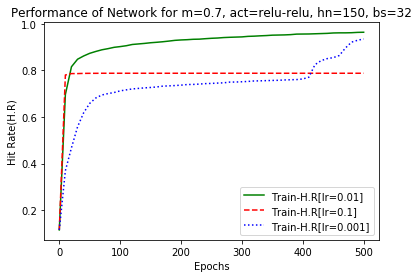

In [68]:
epoch = range(0,501,10)
plt.plot(epoch, Run14_thr, color='g',linestyle='-',label='Train-H.R[lr=0.01]')
plt.plot(epoch, Run15_thr, color='red',linestyle='dashed',label='Train-H.R[lr=0.1]')
plt.plot(epoch, Run16_thr, color='blue',linestyle='dotted',label='Train-H.R[lr=0.001]')

plt.xlabel('Epochs')
plt.ylabel('Hit Rate(H.R)')
plt.legend()
plt.title('Performance of Network for m=0.7, act=relu-relu, hn=150, bs=32')
plt.show()

In [89]:
Run1_tec=[x / 1000 for x in Run1['tec']]
Run1_tc=[x / 3500 for x in Run1['tc']]
Run1_vc=[x / 500 for x in Run1['vc']]
Run2_tec=[x / 1000 for x in Run2['tec']]
Run2_tc=[x / 3500 for x in Run2['tc']]
Run2_vc=[x / 500 for x in Run2['vc']]
Run3_tec=[x / 1000 for x in Run3['tec']]
Run3_tc=[x / 3500 for x in Run3['tc']]
Run3_vc=[x / 500 for x in Run3['vc']]
Run4_tec=[x / 1000 for x in Run4['tec']]
Run4_tc=[x / 3500 for x in Run4['tc']]
Run4_vc=[x / 500 for x in Run4['vc']]
Run5_tec=[x / 1000 for x in Run5['tec']]
Run5_tc=[x / 3500 for x in Run5['tc']]
Run5_vc=[x / 500 for x in Run5['vc']]
Run6_tec=[x / 1000 for x in Run6['tec']]
Run6_tc=[x / 3500 for x in Run6['tc']]
Run6_vc=[x / 500 for x in Run6['vc']]
Run7_tec=[x / 1000 for x in Run7['tec']]
Run7_tc=[x / 3500 for x in Run7['tc']]
Run7_vc=[x / 500 for x in Run7['vc']]
Run8_tec=[x / 1000 for x in Run8['tec']]
Run8_tc=[x / 3500 for x in Run8['tc']]
Run8_vc=[x / 500 for x in Run8['vc']]


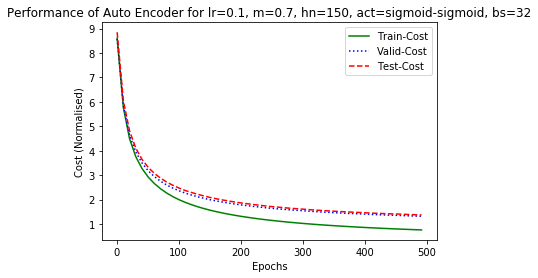

In [119]:
epoch = range(1,501,10)
plt.plot(epoch, Run4_tc[1:], color='g',linestyle='-',label='Train-Cost')
plt.plot(epoch, Run4_vc[1:], color='blue' ,linestyle='dotted',label='Valid-Cost')
plt.plot(epoch, Run4_tec[1:], color='red',linestyle='dashed',label='Test-Cost')
plt.xlabel('Epochs')
plt.ylabel('Cost (Normalised)')
plt.legend()
plt.title('Performance of Auto Encoder for lr=0.1, m=0.7, hn=150, act=sigmoid-sigmoid, bs=32')
plt.show()

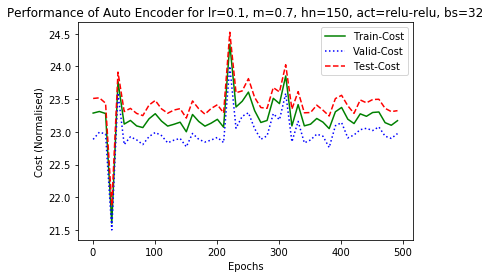

In [120]:
epoch = range(1,501,10)
plt.plot(epoch, Run5_tc[1:], color='g',linestyle='-',label='Train-Cost')
plt.plot(epoch, Run5_vc[1:], color='blue' ,linestyle='dotted',label='Valid-Cost')
plt.plot(epoch, Run5_tec[1:], color='red',linestyle='dashed',label='Test-Cost')
plt.xlabel('Epochs')
plt.ylabel('Cost (Normalised)')
plt.legend()
plt.title('Performance of Auto Encoder for lr=0.1, m=0.7, hn=150, act=relu-relu, bs=32')
plt.show()

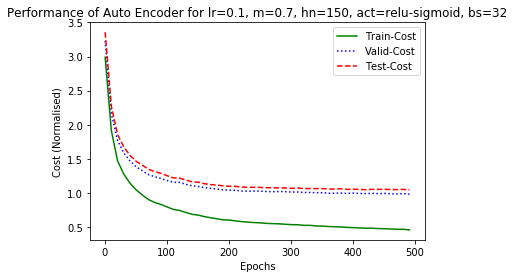

In [121]:
epoch = range(1,501,10)
plt.plot(epoch, Run6_tc[1:], color='g',linestyle='-',label='Train-Cost')
plt.plot(epoch, Run6_vc[1:], color='blue' ,linestyle='dotted',label='Valid-Cost')
plt.plot(epoch, Run6_tec[1:], color='red',linestyle='dashed',label='Test-Cost')
plt.xlabel('Epochs')
plt.ylabel('Cost (Normalised)')
plt.legend()
plt.title('Performance of Auto Encoder for lr=0.1, m=0.7, hn=150, act=relu-sigmoid, bs=32')
plt.show()

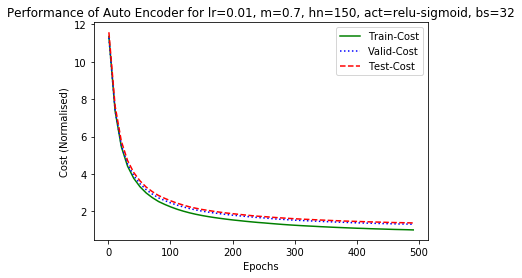

In [114]:
epoch = range(1,501,10)
plt.plot(epoch, Run7_tc[1:], color='g',linestyle='-',label='Train-Cost')
plt.plot(epoch, Run7_vc[1:], color='blue' ,linestyle='dotted',label='Valid-Cost')
plt.plot(epoch, Run7_tec[1:], color='red',linestyle='dashed',label='Test-Cost')
plt.xlabel('Epochs')
plt.ylabel('Cost (Normalised)')
plt.legend()
plt.title('Performance of Auto Encoder for lr=0.01, m=0.7, hn=150, act=relu-sigmoid, bs=32')
plt.show()

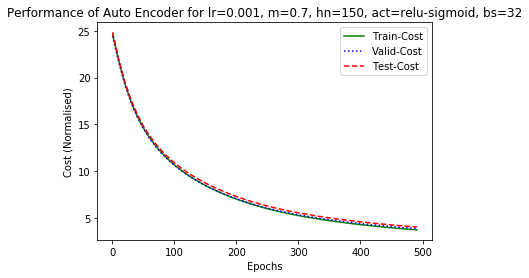

In [112]:
epoch = range(1,501,10)
plt.plot(epoch, Run8_tc[1:], color='g',linestyle='-',label='Train-Cost')
plt.plot(epoch, Run8_vc[1:], color='blue' ,linestyle='dotted',label='Valid-Cost')
plt.plot(epoch, Run8_tec[1:], color='red',linestyle='dashed',label='Test-Cost')
plt.xlabel('Epochs')
plt.ylabel('Cost (Normalised)')
plt.legend()
plt.title('Performance of Auto Encoder for lr=0.001, m=0.7, hn=150, act=relu-sigmoid, bs=32')
plt.show()

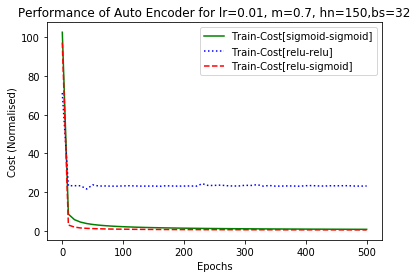

In [107]:
epoch = range(0,501,10)
plt.plot(epoch, Run4_tc, color='g',linestyle='-',label='Train-Cost[sigmoid-sigmoid]')
plt.plot(epoch, Run5_tc, color='blue' ,linestyle='dotted',label='Train-Cost[relu-relu]')
plt.plot(epoch, Run6_tc, color='red',linestyle='dashed',label='Train-Cost[relu-sigmoid]')
plt.xlabel('Epochs')
plt.ylabel('Cost (Normalised)')
plt.legend()
plt.title('Performance of Auto Encoder for lr=0.01, m=0.7, hn=150,bs=32')
plt.show()

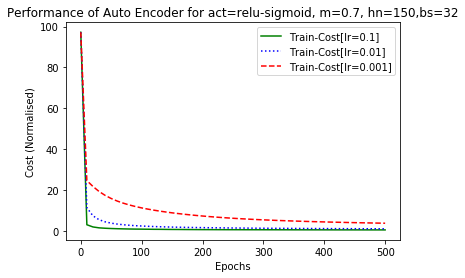

In [111]:
epoch = range(0,501,10)
plt.plot(epoch, Run6_tc, color='g',linestyle='-',label='Train-Cost[lr=0.1]')
plt.plot(epoch, Run7_tc, color='blue' ,linestyle='dotted',label='Train-Cost[lr=0.01]')
plt.plot(epoch, Run8_tc, color='red',linestyle='dashed',label='Train-Cost[lr=0.001]')
plt.xlabel('Epochs')
plt.ylabel('Cost (Normalised)')
plt.legend()
plt.title('Performance of Auto Encoder for act=relu-sigmoid, m=0.7, hn=150,bs=32')
plt.show()

## Metrics and all

In [142]:
def create_conf_matrix(expected, predicted, n_classes):
    m = [[0] * n_classes for i in range(n_classes)]
    for pred, exp in zip(predicted, expected):
        m[int(pred)][int(exp)] += 1
    return m

In [274]:
nn.load(121,0.01,0.7,'model-0.01-0.7relu-relu480.pkl',['NR','relu','relu'])
splRun=nn.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.926 , training hit rate 0.982 , testing hit rate 0.93.
For epoch 10, validating hit rate 0.928 , training hit rate 0.982 , testing hit rate 0.931.
For epoch 20, validating hit rate 0.928 , training hit rate 0.982 , testing hit rate 0.93.
For epoch 30, validating hit rate 0.928 , training hit rate 0.982 , testing hit rate 0.93.
For epoch 40, validating hit rate 0.928 , training hit rate 0.982 , testing hit rate 0.931.
For epoch 50, validating hit rate 0.928 , training hit rate 0.982 , testing hit rate 0.931.
For epoch 60, validating hit rate 0.928 , training hit rate 0.982 , testing hit rate 0.931.
For epoch 70, validating hit rate 0.928 , training hit rate 0.982 , testing hit rate 0.93.
For epoch 80, validating hit rate 0.928 , training hit rate 0.982 , testing hit rate 0.93.
For epoch 90, validating hit rate 0.928 , training hit rate 0.982 , testing hit rate 0.931.
For epoch 100, validating hit rate 0.928 , training hit rate 0.982 , testing hit rate 

In [275]:
pred=[]
org=[]
for feat, targ in data_test:
    org.append(targ)
    pred.append(nn.test(feat))
create_conf_matrix(org,pred,10)

[[88, 1, 1, 1, 0, 2, 3, 0, 1, 2],
 [0, 107, 0, 0, 0, 0, 1, 1, 0, 1],
 [2, 1, 97, 0, 0, 0, 0, 0, 0, 1],
 [0, 3, 2, 93, 0, 2, 0, 0, 1, 1],
 [1, 1, 2, 0, 95, 1, 0, 0, 0, 5],
 [0, 0, 0, 0, 0, 83, 1, 0, 0, 2],
 [1, 1, 0, 0, 2, 2, 87, 0, 3, 1],
 [0, 0, 1, 2, 0, 0, 0, 98, 1, 1],
 [0, 0, 3, 2, 1, 0, 0, 1, 92, 2],
 [0, 0, 0, 2, 2, 1, 0, 3, 0, 88]]

In [276]:
pred1=[]
org1=[]
for feat, targ in data_val:
    org1.append(targ)
    pred1.append(nn.test(feat))
create_conf_matrix(org1,pred1,10)

[[45, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 55, 0, 0, 0, 1, 0, 1, 0, 1],
 [0, 0, 48, 1, 0, 0, 0, 1, 1, 1],
 [0, 0, 1, 46, 0, 2, 0, 1, 0, 0],
 [0, 0, 1, 0, 47, 0, 1, 1, 1, 1],
 [0, 0, 0, 1, 0, 40, 0, 0, 1, 1],
 [1, 0, 2, 0, 1, 2, 45, 0, 0, 0],
 [0, 1, 0, 1, 0, 1, 0, 47, 1, 0],
 [0, 1, 1, 0, 0, 0, 0, 0, 45, 1],
 [0, 0, 0, 0, 2, 0, 0, 0, 0, 47]]

In [277]:
pred1=[]
org1=[]
for feat, targ in data_train:
    org1.append(np.argmax(targ))
    pred1.append(nn.test(feat))
create_conf_matrix(org1,pred1,10)

[[321, 0, 4, 2, 0, 1, 4, 1, 7, 4],
 [0, 398, 0, 0, 0, 0, 1, 1, 1, 3],
 [0, 1, 360, 0, 0, 0, 0, 0, 1, 0],
 [0, 1, 2, 342, 0, 1, 0, 0, 5, 3],
 [0, 0, 1, 0, 350, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 315, 0, 1, 1, 0],
 [0, 0, 1, 1, 0, 0, 319, 0, 1, 0],
 [1, 0, 2, 1, 0, 1, 0, 355, 0, 1],
 [0, 0, 1, 2, 0, 1, 0, 0, 325, 0],
 [0, 0, 0, 2, 0, 0, 0, 0, 0, 352]]

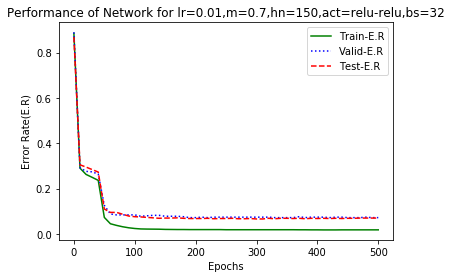

In [278]:
epoch = range(0,501,10)
plt.plot(epoch, [1-x for x in Run13_thr], color='g',linestyle='-',label='Train-E.R')
plt.plot(epoch, [1-x for x in Run13_vhr], color='blue' ,linestyle='dotted',label='Valid-E.R')
plt.plot(epoch, [1-x for x in Run13_tehr], color='red',linestyle='dashed',label='Test-E.R')
plt.xlabel('Epochs')
plt.ylabel('Error Rate(E.R)')
plt.legend()
plt.title('Performance of Network for lr=0.01,m=0.7,hn=150,act=relu-relu,bs=32')
plt.show()

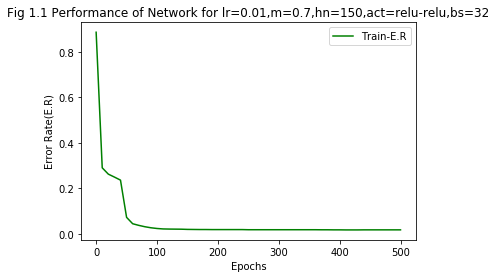

In [279]:
epoch = range(0,501,10)
plt.plot(epoch, [1-x for x in Run13_thr], color='g',linestyle='-',label='Train-E.R')
plt.xlabel('Epochs')
plt.ylabel('Error Rate(E.R)')
plt.legend()
plt.title('Fig 1.1 Performance of Network for lr=0.01,m=0.7,hn=150,act=relu-relu,bs=32')
plt.show()

In [253]:
nn.load(322,0.1,0.7,'auto-0.1-0.7relu-sigmoid480.pkl',['NR','relu','sigmoid'])
SplAutoRun6=nn.train(data_train_auto, data_val_auto, data_test_auto,True)

For epoch 0, validating error 491.57319492673474 , training error 1630.3500640838581 , testing error 1047.5014349412202.
For epoch 10, validating error 493.6884964676065 , training error 1625.1623800125958 , testing error 1050.3603892132837.
For epoch 20, validating error 492.96168472956174 , training error 1607.6399279108964 , testing error 1044.9641926102488.
For epoch 30, validating error 490.16079412342015 , training error 1586.5978156164952 , testing error 1039.9761628257659.
For epoch 40, validating error 491.52828225504936 , training error 1581.4940822255687 , testing error 1042.6066712954287.
For epoch 50, validating error 490.8375261776971 , training error 1568.7368849925329 , testing error 1040.3394334187165.
For epoch 60, validating error 490.29479098107424 , training error 1567.1690099133011 , testing error 1039.711729486009.
For epoch 70, validating error 491.8898674963797 , training error 1556.234438708823 , testing error 1045.561610738652.
For epoch 80, validating error 

In [23]:
# After balanced split

#initialize layer sizes as list
layers = [784,150,784]
act_funcs=['NR','relu','sigmoid']
momentum = 0.7
lr = 0.1
itrs = 1
batch_size = 32

nn = Model(layers,act_funcs, lr, momentum, itrs, batch_size,True)

#training neural network
spl_Run_hiddenfeatures=nn.train(data_train_auto, data_val_auto, data_test_auto,True)



For epoch 0, validating error 47316.157105828956 , training error 331003.46323479625 , testing error 94568.2448476143.


In [25]:
nn.load(1,0.1,0.7,'auto-0.1-0.7relu-sigmoid300.pkl',['NR','relu','sigmoid'])
sp_auto_run=nn.train(data_train_auto, data_val_auto, data_test_auto,True)

For epoch 0, validating error 493.1077423030242 , training error 1434.1333619446532 , testing error 1042.5554139945352.


In [27]:
sp_auto_run_TEC=sp_auto_run['tec'][-1]
sp_auto_run_TC=sp_auto_run['tc'][-1]

##  Here normalised cost is such that overall loss calculated is divided by their number of data points

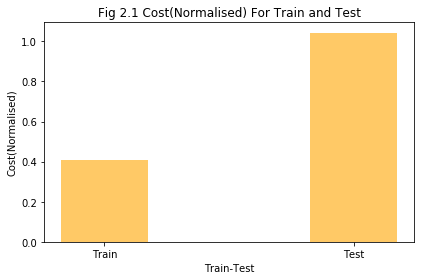

In [52]:
# data to plot
metric_count = 2
cost_metrics = (sp_auto_run_TC/3500, sp_auto_run_TEC/1000) 
# create plot
fig, ax = plt.subplots()
index = np.arange(metric_count)
bar_width = 0.35
opacity = 0.6
rects1 = plt.bar(index, cost_metrics, bar_width,
                 alpha=opacity,
                 color='orange')
 

plt.xlabel('Train-Test')
plt.ylabel('Cost(Normalised)')
plt.title('Fig 2.1 Cost(Normalised) For Train and Test')
plt.xticks(index, ('Train', 'Test'))
plt.tight_layout()
plt.show()

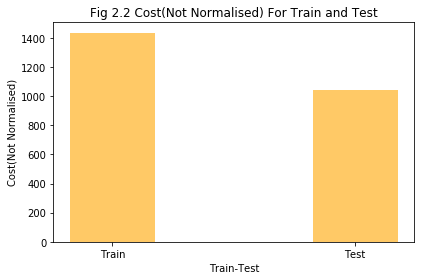

In [53]:
# data to plot
metric_count = 2
cost_metrics = (sp_auto_run_TC, sp_auto_run_TEC) 
# create plot
fig, ax = plt.subplots()
index = np.arange(metric_count)
bar_width = 0.35
opacity = 0.6
rects1 = plt.bar(index, cost_metrics, bar_width,
                 alpha=opacity,
                 color='orange')
 

plt.xlabel('Train-Test')
plt.ylabel('Cost(Not Normalised)')
plt.title('Fig 2.2 Cost(Not Normalised) For Train and Test')
plt.xticks(index, ('Train', 'Test'))
plt.tight_layout()
plt.show()

In [31]:
digits_train_cost=[]
digits_train_cost_unnorm=[]
for i in range(0,10):
    tmpind=Y_train_new[Y_train_new.iloc[:,0]==i].index.tolist()
    tmp_arr_x_train_auto = [np.reshape(X_train_new.loc[j,:].tolist(), (len(X_train_new.columns), 1)) for j in tmpind]
    tmp_data_train_auto = list(zip(tmp_arr_x_train_auto, tmp_arr_x_train_auto))
    tmp_train_cost = nn.getError(tmp_data_train_auto)/ len(tmp_data_train_auto)
    digits_train_cost.append(tmp_train_cost)
    digits_train_cost_unnorm.append(nn.getError(tmp_data_train_auto))
    
digits_test_cost=[]
digits_test_cost_unnorm=[]

for i in range(0,10):
    tmpind=Y_test[Y_test.iloc[:,0]==i].index.tolist()
    tmp_arr_x_test_auto = [np.reshape(X_test.loc[j,:].tolist(), (len(X_test.columns), 1)) for j in tmpind]
    tmp_data_test_auto = list(zip(tmp_arr_x_test_auto, tmp_arr_x_test_auto))
    tmp_test_cost = nn.getError(tmp_data_test_auto)/ len(tmp_data_test_auto)
    digits_test_cost.append(tmp_test_cost)
    digits_test_cost_unnorm.append(nn.getError(tmp_data_test_auto))

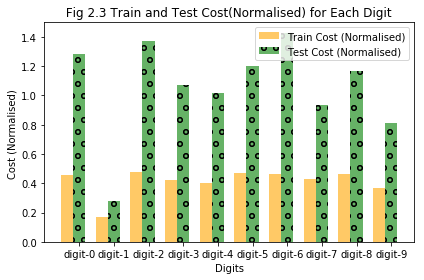

In [54]:
# data to plot
metric_count = 10

# create plot
fig, ax = plt.subplots()
index = np.arange(metric_count)
bar_width = 0.35
opacity = 0.6
rects1 = plt.bar(index, digits_train_cost, bar_width,
                 alpha=opacity,
                 color='orange',
                 label='Train Cost (Normalised)')
 
rects2 = plt.bar(index + bar_width, digits_test_cost, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Test Cost (Normalised)',hatch='o')
plt.xlabel('Digits')
plt.ylabel('Cost (Normalised) ')
plt.title(' Fig 2.3 Train and Test Cost(Normalised) for Each Digit ')
plt.xticks(index + bar_width, ('digit-0', 'digit-1', 'digit-2', 'digit-3','digit-4','digit-5', 'digit-6', 'digit-7', 'digit-8','digit-9'))
plt.legend()
plt.tight_layout()
plt.show()

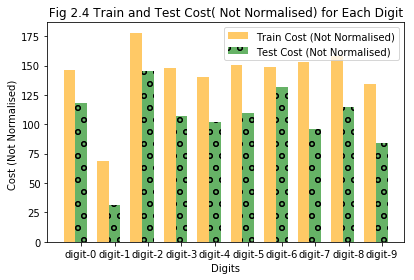

In [55]:
# data to plot
metric_count = 10

# create plot
fig, ax = plt.subplots()
index = np.arange(metric_count)
bar_width = 0.35
opacity = 0.6
rects1 = plt.bar(index, digits_train_cost_unnorm, bar_width,
                 alpha=opacity,
                 color='orange',
                 label='Train Cost (Not Normalised)')
 
rects2 = plt.bar(index + bar_width, digits_test_cost_unnorm, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Test Cost (Not Normalised)',hatch='o')
plt.xlabel('Digits')
plt.ylabel('Cost (Not Normalised) ')
plt.title(' Fig 2.4 Train and Test Cost( Not Normalised) for Each Digit ')
plt.xticks(index + bar_width, ('digit-0', 'digit-1', 'digit-2', 'digit-3','digit-4','digit-5', 'digit-6', 'digit-7', 'digit-8','digit-9'))
plt.legend()
plt.tight_layout()
plt.show()

## Plotting random test input image and viewing reconstructed image

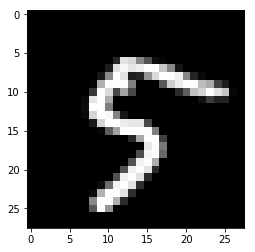

In [36]:
pixels = arr_x_test[0].reshape((28, 28),order='F')
plt.imshow(pixels, cmap='gray')

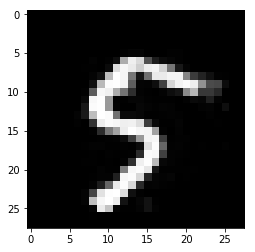

In [37]:
pixels2 = nn.test_auto(arr_x_test[0]).reshape((28, 28),order='F')
plt.imshow(pixels2, cmap='gray')

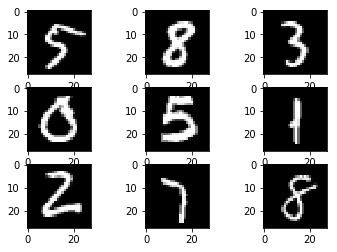

In [38]:
for i in range(9):
    pixels = arr_x_test[i+9*i].reshape((28, 28),order='F')
    plt.subplot(3,3,i+1)
    plt.imshow(pixels, cmap='gray')

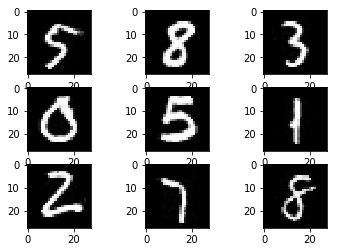

In [39]:
for i in range(9):
    #pixels = arr_x_train[i].reshape((28, 28),order='F')
    pixels2 = nn.test_auto(arr_x_test[i+9*i]).reshape((28, 28),order='F')
    plt.subplot(3,3,i+1)
    plt.imshow(pixels2, cmap='gray')

## Plotting weights between input and hidder layer as feature maps

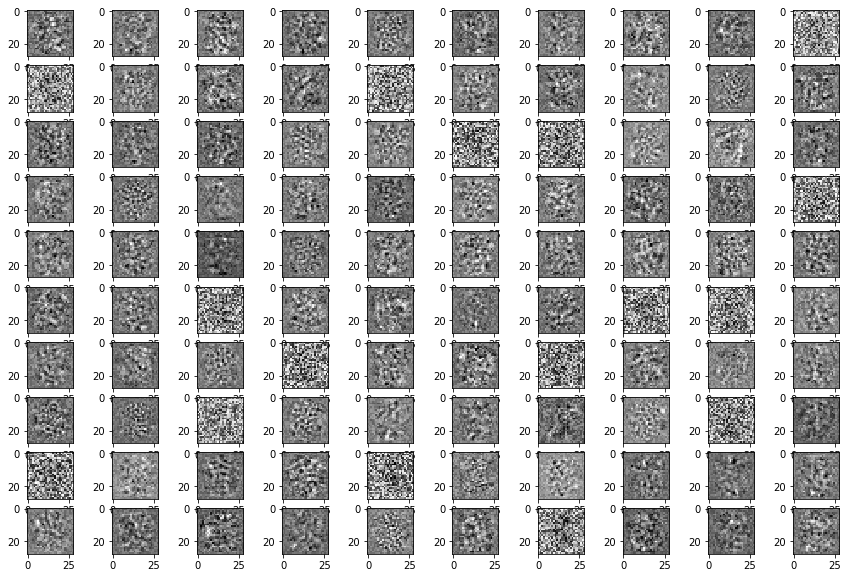

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))

for i in range(100):
    pixels2 = nn.W[1][i].reshape((28, 28),order='F')
    plt.subplot(10,10,i+1)
    plt.imshow(pixels2, cmap='gray')

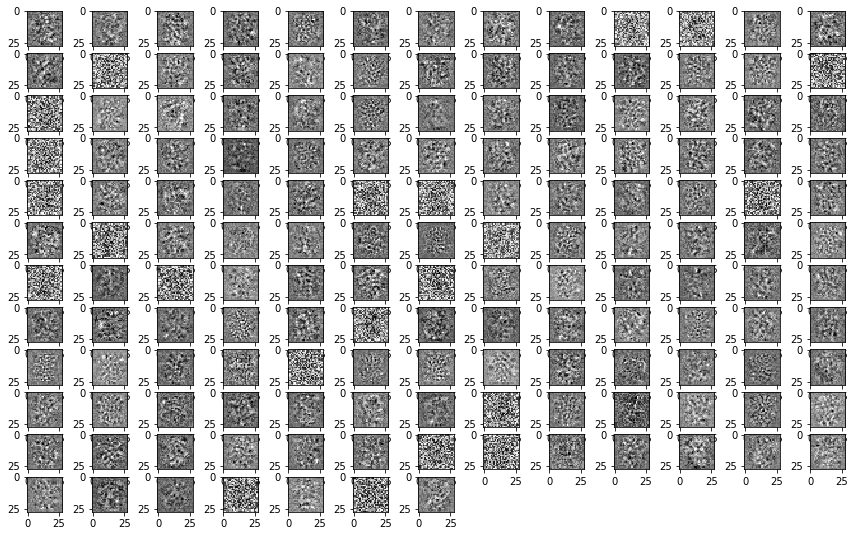

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))

for i in range(150):
    #pixels = arr_x_train[i].reshape((28, 28),order='F')
    pixels2 = nn.W[1][i].reshape((28, 28),order='F')
    plt.subplot(13,13,i+1)
    plt.imshow(pixels2, cmap='gray')

In [47]:
len(nn.W[2])

784

## Plotting weights between hidder layer and output layer as feature maps

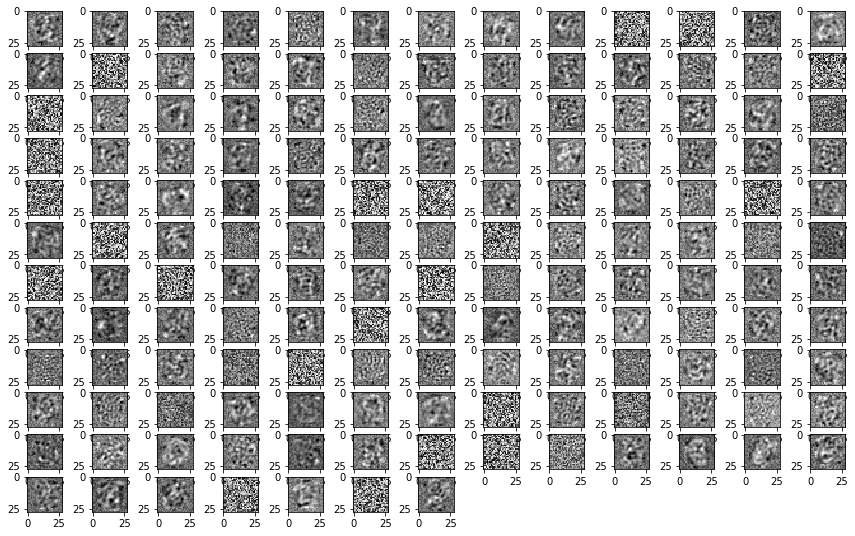

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
for i in range(150):
    #pixels = arr_x_train[i].reshape((28, 28),order='F')
    pixels2 = nn.W[2][:,i].reshape((28, 28),order='F')
    plt.subplot(13,13,i+1)
    plt.imshow(pixels2, cmap='gray')